In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [2]:
# Read the dataset
df = pd.read_csv('https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_card_customers.csv')
RANDOM_SEED = 1
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
df.shape # count the values in the dataframe

(8950, 18)

In [4]:
df.isna().sum() # Check if there are missing data in the columns

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [5]:
df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].mean(), inplace=True) # Handling missing data and replacing with the mean

In [6]:
df.dropna(subset=["CREDIT_LIMIT"], inplace=True) # Remove rows and columns with missing values in the CREDIT_LIMIT column

In [7]:
df.drop("CUST_ID",axis=1, inplace=True) # Remove colums CUST_ID 

In [8]:
df.isna().sum()  # Check for missing data

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

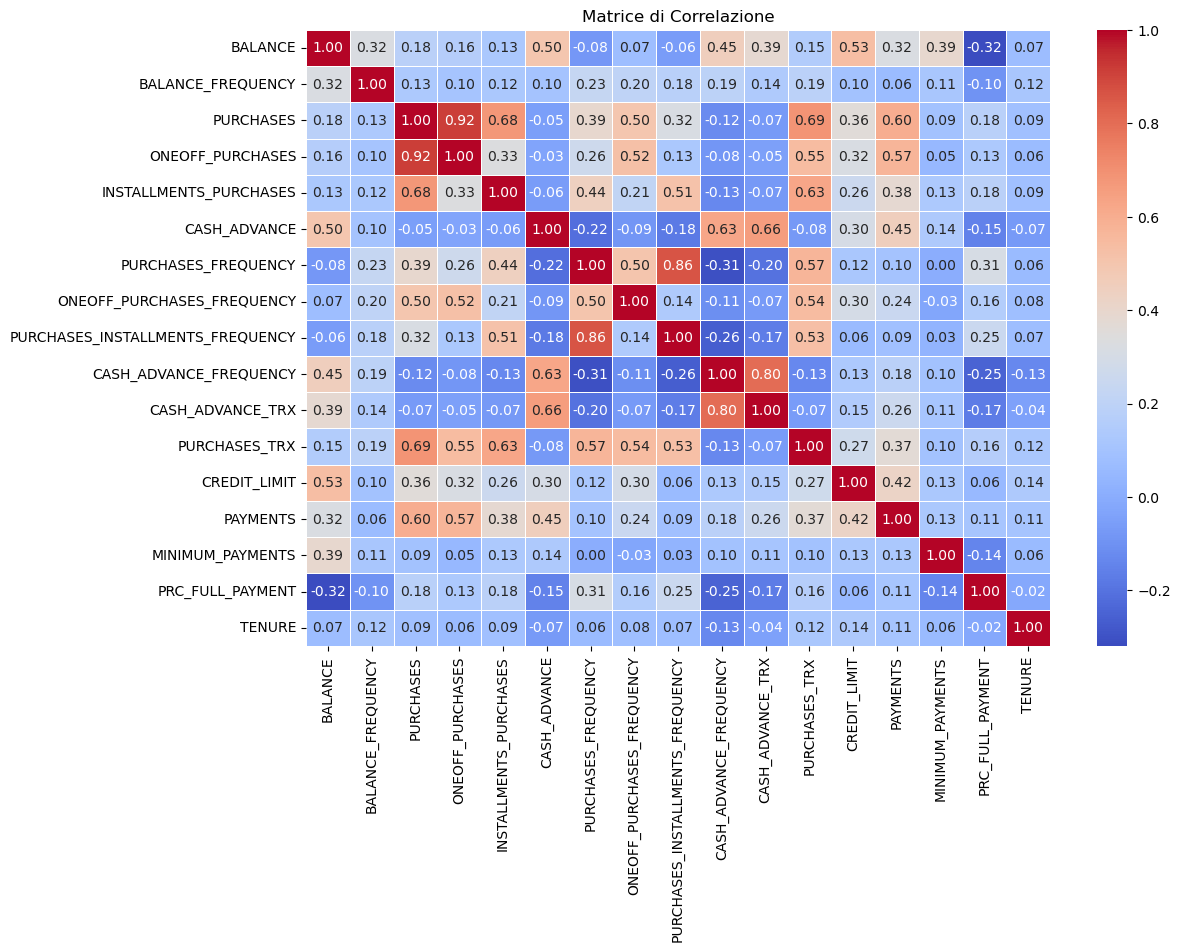

In [9]:
# Show the correlation matrix"

correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice di Correlazione")
plt.show()


<p style="color:blue; font-size:20px">PURCHASES_FREQUENCY has a positive correlation with most other variables, meaning that the more often you make purchases the higher the other values.  </p>

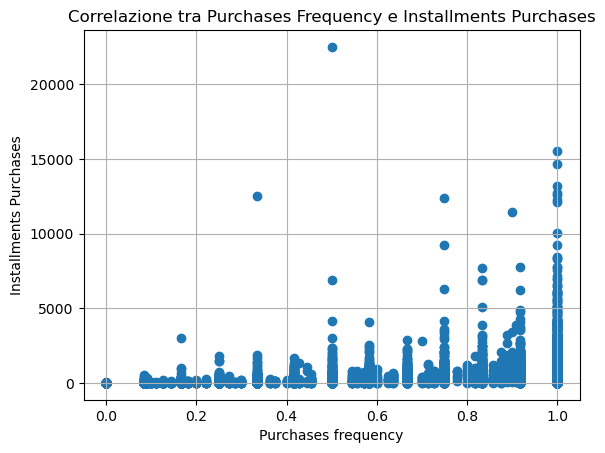

In [10]:
# The correlation between the features PURCHASES_FREQUENCY and INSTALLMENTS_PURCHASES

purchases_frequency = df["PURCHASES_FREQUENCY"].values
installments_purchases = df["INSTALLMENTS_PURCHASES"].values


plt.scatter(purchases_frequency, installments_purchases)


plt.xlabel("Purchases frequency")
plt.ylabel("Installments Purchases")
plt.title("Correlazione tra Purchases Frequency e Installments Purchases")

plt.grid()
plt.show()


<p style="color:red; font-size:21px"> PURCHASES_FREQUENCY and INSTALLAMENTS_PURCHASES have a strong positive correlation when the frequency of purchases increases, installment purchases also increase and vice versa </p>

In [11]:
scaler_X = StandardScaler()  # Normalize the data using StandardScaler.
colums_to_normalize = ["PURCHASES_FREQUENCY", "INSTALLMENTS_PURCHASES"]
df[colums_to_normalize] = scaler_X.fit_transform(df[colums_to_normalize])

In [12]:
# Function to visualize the SSD (Sum of Squared Differences) curve

def plot_ssd_curve(X, k_range=(1, 11)):
    ssd = []
    for k in range(k_range[0], k_range[1]):
        kmeans = KMeans(n_clusters=k, init="k-means++", random_state=RANDOM_SEED)
        kmeans.fit(X)
        ssd.append(kmeans.inertia_)
        
    plt.figure(figsize=(10, 6))
    plt.plot(range(k_range[0], k_range[1]), ssd, "o-" , color="blue")
    plt.title("Curva del gomito per il metodo del K-Means")
    plt.xlabel("Numero di cluster")
    plt.ylabel("Somma delle distanze quadratriche")
    plt.grid()
    plt.show()

In [13]:
# Function to visualize the clusters

def plot_clusters(model, data, axlabels=["PURCHASES_FREQUENCY", "INSTALLMENTS_PURCHASES"], print_ssd=False):
    # Assign the cluster centers
    centers = model.cluster_centers_
    
    y_kmeans = model.predict(data)
    
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=y_kmeans, s=100, palette="viridis", alpha=0.6)
    
    plt.scatter(centers[:, 0], centers[:, 1], c="red", s=200, alpha=0.5, label='Centroidi')
    
    if axlabels is not None:
        plt.xlabel(axlabels[0], fontsize=16)
        plt.ylabel(axlabels[1], fontsize=16)
    
    if print_ssd:
        plt.text(plt.xlim()[1]*0.7, plt.ylim()[1]*0.8, f"SSD = {model.inertia_:.2f}")
    plt.legend()
    plt.title("Visualizzazione dei Cluster")
    plt.grid()
    plt.show()

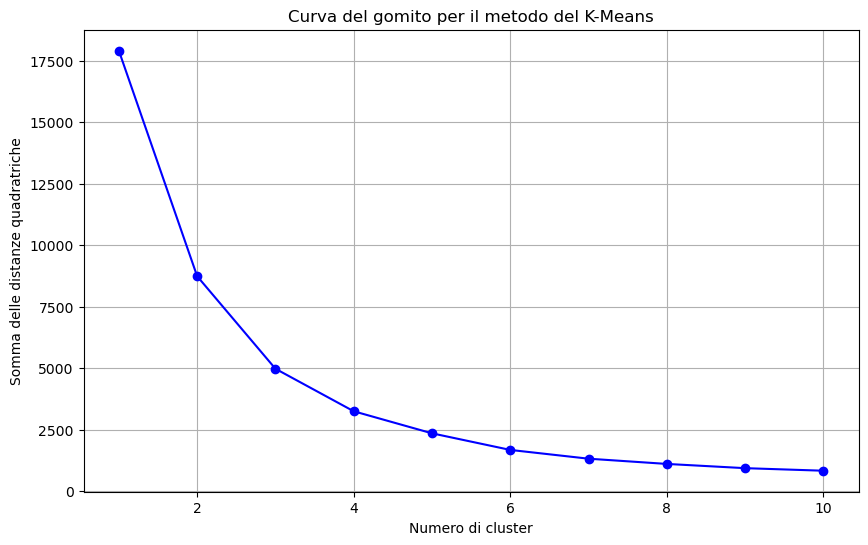

In [14]:
X = df[colums_to_normalize].values  # Find the number of clusters

plot_ssd_curve(X)

In [15]:
kmeans = KMeans(n_clusters=5, init="k-means++", random_state=RANDOM_SEED)  # Create and train the KMeans model
kmeans.fit(X)


KMeans(n_clusters=5, random_state=1)

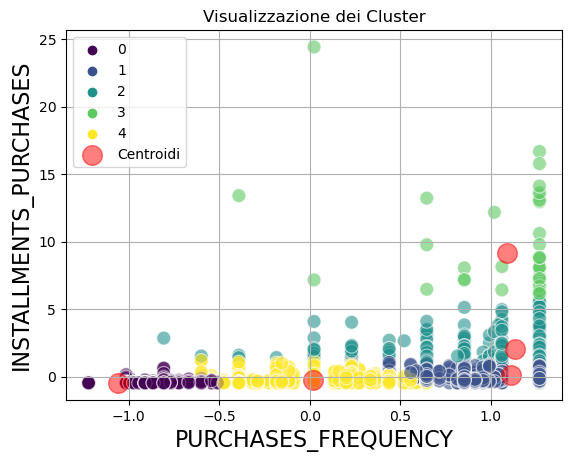

In [16]:
# Show the clusters

plot_clusters(kmeans, X)

<span style="color:violet; font-size:21px"> The graph shows the cluster visualization based on the frequency of purchases. There are five clusters indicated by different colors, and the centroids of each cluster are highlighted with larger circles. </span>

In [17]:
# Load the new data for prediction.

df_pred = pd.read_csv("https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_card_customers.csv")
# Normalizzare le colonne di interesse
X_pred = scaler_X.transform(df_pred[colums_to_normalize])

In [18]:
# Predict the clusters for the new normalized data.

y_kmeans_pred = kmeans.predict(X_pred)

In [19]:
# Create a DataFrame with the prediction results.

df_result = pd.DataFrame({
    "CUST_ID": df_pred["CUST_ID"],
    "Gruppo Cliente": y_kmeans_pred,
    "PURCHASES_FREQUENCY_NORMALIZED": X_pred[:, 0],
    "INSTALLMENTS_PURCHASES_FREQUENCY_NORMALIZED": X_pred[:, 1]
})


In [20]:
# Show the rows of the resulting DataFrame

df_result.head()

,CUST_ID,Gruppo Cliente,PURCHASES_FREQUENCY_NORMALIZED,INSTALLMENTS_PURCHASES_FREQUENCY_NORMALIZED
0,C10001,0,-0.806649,-0.349114
1,C10002,0,-1.221928,-0.454607
2,C10003,1,1.269742,-0.454607
3,C10004,0,-1.014290,-0.454607
4,C10005,0,-1.014290,-0.454607


In [21]:
# Function to calculate statistics for each group
groups = df_result.groupby('Gruppo Cliente')


def calculate_statistics(group):
    customer_count = group.shape[0]
    media_acquisti = group["PURCHASES_FREQUENCY_NORMALIZED"].mean()
    media_acquisti_rate = group["INSTALLMENTS_PURCHASES_FREQUENCY_NORMALIZED"].mean()
    rmse_acquisti = ((group["PURCHASES_FREQUENCY_NORMALIZED"] - media_acquisti) ** 2).mean() ** 0.5
    rmse_acquisti_rate = ((group["INSTALLMENTS_PURCHASES_FREQUENCY_NORMALIZED"] - media_acquisti_rate) ** 2).mean() ** 0.5
    
    return pd.Series({
        "Conteggio clienti": customer_count,
        "Media frequenza acquisti": media_acquisti,
        "RMSE frequenza acquisti": rmse_acquisti,
        "Media frequenza acquisti a rate": media_acquisti_rate,
        "RMSE frequenza acquisti a rate": rmse_acquisti_rate
    })


result_for_group = groups.apply(calculate_statistics)

print(result_for_group)

                Conteggio clienti  Media frequenza acquisti  \
Gruppo Cliente                                                
0                          3658.0                 -1.060906   
1                          2796.0                  1.112141   
2                           605.0                  1.132555   
3                            44.0                  1.089473   
4                          1847.0                  0.019974   

                RMSE frequenza acquisti  Media frequenza acquisti a rate  \
Gruppo Cliente                                                             
0                              0.212053                        -0.439360   
1                              0.223997                         0.118501   
2                              0.310489                         2.080403   
3                              0.377293                         9.164099   
4                              0.309333                        -0.209242   

                RMSE freq

In [22]:
#  Export the results to an Excel file

#df_result.to_excel("previsioni_creditcard_con_dati_addestrati.xlsx", index=False)

<p>Here is a summary of the descriptive statistics for each "Customer Group" based on normalized frequency of purchases and rate purchases:

- **Customer Group 0**: Has a large number of customers (3658), but low average values for both purchase frequency and installment purchase frequency, indicating that these customers purchase less frequently.
-**Customer Group 1**: Also has a significant number of customers (2796) with much higher average values for purchase frequency, suggesting that they are more active in purchasing.
-**Customer Group 2**: Has fewer customers (605) but high average values for the frequency of interest purchases, which could indicate a cluster with high potential value for campaigns that focus on interest purchases.
-**Customer Group 3**: The smallest group (44 customers) but with exceptionally high average values for rate purchase frequency, suggesting they make rate purchases frequently and could be a very responsive but niche target for campaigns.
-**Customer Group 4**: Moderate in size (1847 customers) with an average purchase frequency close to zero, indicating fluctuating customer behavior.
    
From this data, the company might consider focusing its marketing efforts on Customer Group 2. Campaigns for Customer Group 2 focus on offers based on rate purchases, as they show very high frequencies in rate purchases.</p>